In [1]:
# https://github.com/LukeDitria/pytorch_tutorials/blob/main/section05_transfer_learning/notebooks/Pytorch1_Transfer_Learning.ipynb

In [2]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from src.model_trainer import ModelTrainer

In [3]:
batch_size = 64
best_valid_acc = 0
dataset_root = "../temp"
image_size = 96
learning_rate = 1e-4
num_epochs = 10
start_epoch = 0

In [4]:
model_name = "ResNet18_STL10"
save_dir = "../temp"
start_from_checkpoint = False

In [5]:
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

In [6]:
from torch.utils.data import DataLoader

dataset = datasets.STL10(dataset_root, split='train', download=True, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# Initialize variables
n_samples = 0
mean = torch.zeros(3)
std = torch.zeros(3)

for data, _ in dataloader:
    # Rearrange batch to be the shape of [B, C, W * H]
    data = data.view(data.size(0), data.size(1), -1)
    # Update total number of images
    n_samples += data.size(0)
    # Compute mean and std here
    mean += data.mean(2).sum(0) 
    std += data.std(2).sum(0)

# Final calculation
mean /= n_samples
std /= n_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

# Mean: tensor([0.4467, 0.4398, 0.4066])
# Std: tensor([0.2242, 0.2215, 0.2239])

Files already downloaded and verified
Mean: tensor([0.4467, 0.4398, 0.4066])
Std: tensor([0.2242, 0.2215, 0.2239])


In [6]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 

In [7]:
train_data = datasets.STL10(dataset_root, split='train', download=True, transform=transform)
test_data = datasets.STL10(dataset_root, split='test', download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
validation_split = 0.9

n_train_examples = int(len(train_data)*validation_split)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(
    train_data,
    [n_train_examples, n_valid_examples],
    generator=torch.Generator().manual_seed(42)
)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 4500
Number of validation examples: 500
Number of testing examples: 8000


In [9]:
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
ftrs_num = resnet.fc.in_features
print(ftrs_num)

resnet.fc = nn.Linear(ftrs_num, 10)

512


In [11]:
model_trainer = ModelTrainer(
    batch_size=batch_size,
    device=device,
    learning_rate=learning_rate, 
    loss_fun=nn.CrossEntropyLoss(), 
    model_name=model_name, 
    model=resnet,
    save_dir=save_dir,
    start_from_checkpoint=start_from_checkpoint
)

Starting from scratch


In [12]:
model_trainer.set_data(train_data=train_data, valid_data=valid_data, test_data=test_data)

Number of training examples: 4500
Number of validation examples: 500
Number of testing examples: 8000


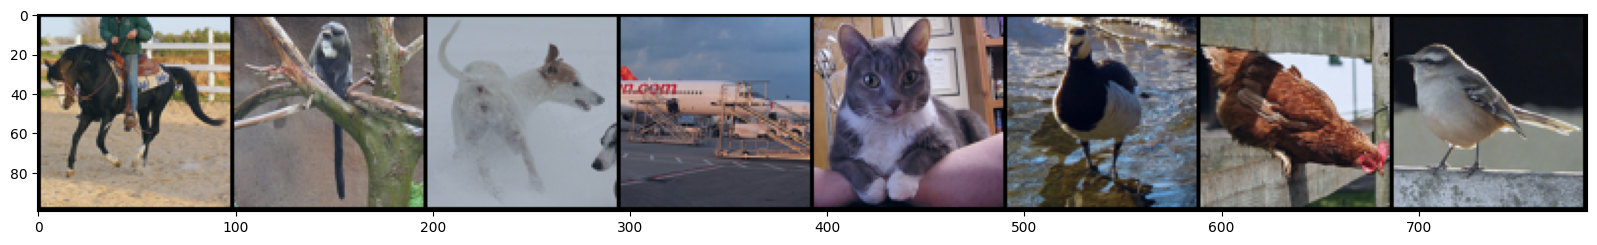

In [13]:
plt.figure(figsize = (20,10))
images, labels = next(iter(model_trainer.test_loader))
out = torchvision.utils.make_grid(images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [17]:
params_num = 0
for param in model_trainer.model.parameters():
    params_num += param.flatten().shape[0]
print("This model has %d (approximately %d Million) Parameters!" % (params_num, params_num / 1e6))

This model has 11181642 (approximately 11 Million) Parameters!


In [18]:
start_time = time.time()
valid_acc = 0
train_acc = 0

pbar = trange(start_epoch, num_epochs, leave=False, desc="Epoch")    
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))
    
    model_trainer.train_model()
    
    train_acc = model_trainer.evaluate_model(train_test_val="train")
    valid_acc = model_trainer.evaluate_model(train_test_val="val")
    
    if valid_acc > model_trainer.best_valid_acc:
        model_trainer.save_checkpoint(epoch, valid_acc)

end_time = time.time()

In [19]:
print("The highest validation accuracy was %.2f%%" %(model_trainer.best_valid_acc*100))

The highest validation accuracy was 88.40%


In [20]:
print("Training time %.2f seconds" %(end_time - start_time))

Training time 1805.77 seconds


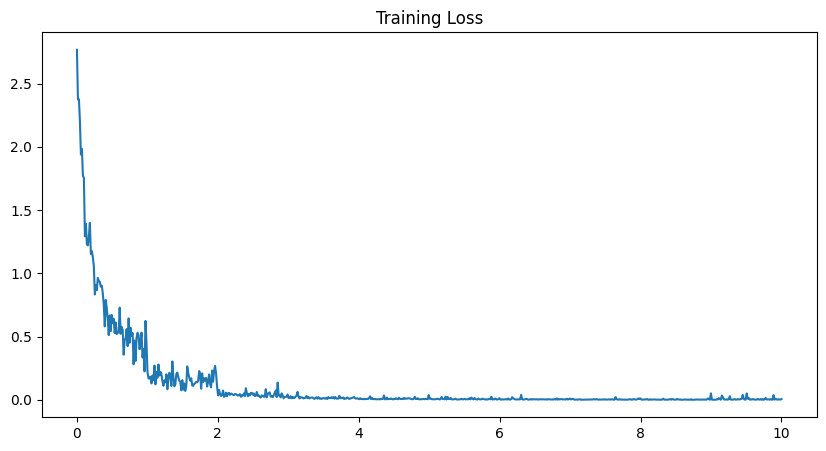

In [21]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_loss_logger))
_ = plt.plot(train_x, model_trainer.train_loss_logger)
_ = plt.title("Training Loss")

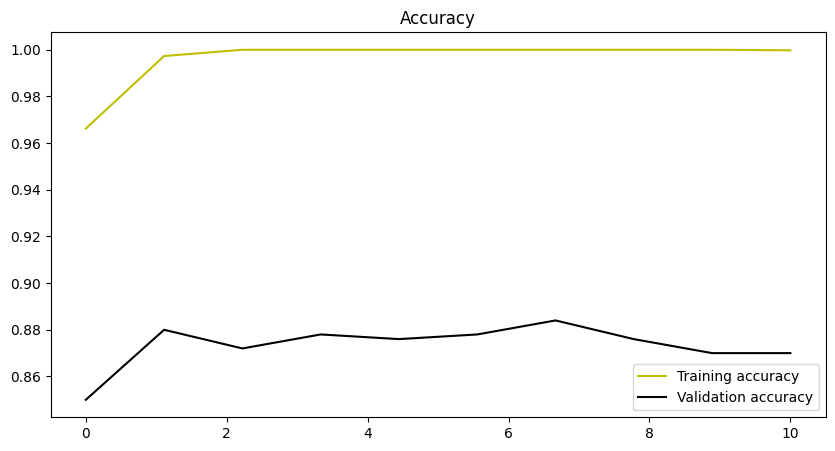

In [22]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_acc_logger))
_ = plt.plot(train_x, model_trainer.train_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(model_trainer.val_acc_logger))
_ = plt.plot(valid_x, model_trainer.val_acc_logger, c = "k")

_ = plt.title("Accuracy")
_ = plt.legend(["Training accuracy", "Validation accuracy"])

In [23]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = model_trainer.evaluate_model(train_test_val="test")
print("The Test Accuracy is: %.2f%%" %(test_acc*100))

The Test Accuracy is: 88.17%
